In [51]:
# Import the Earth Engine Python Package
import ee

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

ee.Initialize()

# use matplotlib converters for plotting?
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [71]:
## define python functions

# function to find max value in a dataframe with DateTime column
def find_max(df, index):

    max_value = np.nanmax(df.iloc[:, index])
    
    t_max = df[df.iloc[:, index]  == max_value].DateTime.tolist()[0] 
    
    return max_value, t_max

def water_max_plot(df, name, index, zoom = False):
    
    # calculate max location    
    max_value, t_max = find_max(df, index)
    
    # matplotlib stuff
    plt.figure(num=None, figsize=(16,9), dpi=80, facecolor='w', edgecolor='w')
    ax = plt.subplot(111)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if not zoom:
        ax.set_ylim([0, 200000])
        
    plt.grid(alpha = .2)
    register_matplotlib_converters()

    # plot max lines
    plt.axvline(x = t_max, color = 'black',linestyle = '--', alpha = .5, label = 'highes value')
    plt.axhline(y = max_value, alpha = .5, linestyle = '--', label = 'abs max')

    # plot data and running mean
    plt.plot(df.DateTime,df.size_water, 'bo', alpha = .2, label = 'measurements')
    plt.plot(df.DateTime, df.iloc[:, index], color = 'red', label = 'running mean')

    plt.title(' Total water area over time for: ' + name + ' \n' +\
              ' Time at max value: ' + t_max.strftime("%Y-%m-%d"))

    plt.xlabel('Time')
    plt.ylabel('Area')

    plt.legend()
    plt.show()

In [72]:
## create Google Earth Engine functions

# create buffer function
def buffer1k(feature):
    return feature.buffer(500)

def waterfunction(image):
  
    image2 = image  .reproject(crs ='EPSG:4326', scale = SCALE)\
                      .focal_mode()\
                      .focal_max(3).focal_min(5).focal_max(3)\
                      .reproject(crs ='EPSG:4326', scale = SCALE)
  
    # get pixels above the threshold
    water01 = image2.lt(-12)
    # mask those pixels from the image
    image = image.updateMask(water01)
    #  calculate pixelalreas
    area = ee.Image.pixelArea()
    waterArea = water01.multiply(area).rename('waterArea');
    #   add waterarea band to uitput
    image = image.addBands(waterArea)

    return image

# reducer function for area calculation
def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.sum(), AOI_geometry)
    return image.set(dict)



# Get number of pixels for point buffers


In [73]:
# define points of interest

features = [
  ee.Feature(ee.Geometry.Point(106.83471,-6.197928), {'name': 'Situ Lembang'}),
  ee.Feature(ee.Geometry.Point(106.80394,-6.211232), {'name': 'Waduk Taman Ria Senayan'}),
  ee.Feature(ee.Geometry.Point(106.82223,-6.349455), {'name': 'Situ Mangga Bolong'}),
  ee.Feature(ee.Geometry.Point(106.82136,-6.314984), {'name': 'Waduk Ragunan'}), 
  ee.Feature(ee.Geometry.Point(106.82221,-6.343443), {'name': 'Situ Babakan'}),
  ee.Feature(ee.Geometry.Point(106.84812,-6.257327), {'name': 'Situ TMP Kalibata'}),
  ee.Feature(ee.Geometry.Point(106.88793,-6.357405), {'name': 'Situ Rawa Dongkal'}),
  ee.Feature(ee.Geometry.Point(106.92210,-6.211445), {'name': 'Situ Rawa Badung'}), 
  ee.Feature(ee.Geometry.Point(106.91205,-6.202781), {'name': 'Situ Rawa Gelam'}), 
  ee.Feature(ee.Geometry.Point(106.88569,-6.338337), {'name': 'Rawa Babon'}),
  ee.Feature(ee.Geometry.Point(106.89472,-6.304803), {'name': 'Situ Rawa TMII'}),
  ee.Feature(ee.Geometry.Point(106.93248,-6.196898), {'name': 'Situ Rawa Penggilingan'}),
  ee.Feature(ee.Geometry.Point(106.95598,-6.163825), {'name': 'Situ Rawa Rorotan'}),
  ee.Feature(ee.Geometry.Point(107.03692,-6.351368), {'name': 'Rawa Burankeng'})
];

# Collect and plot data

In [55]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

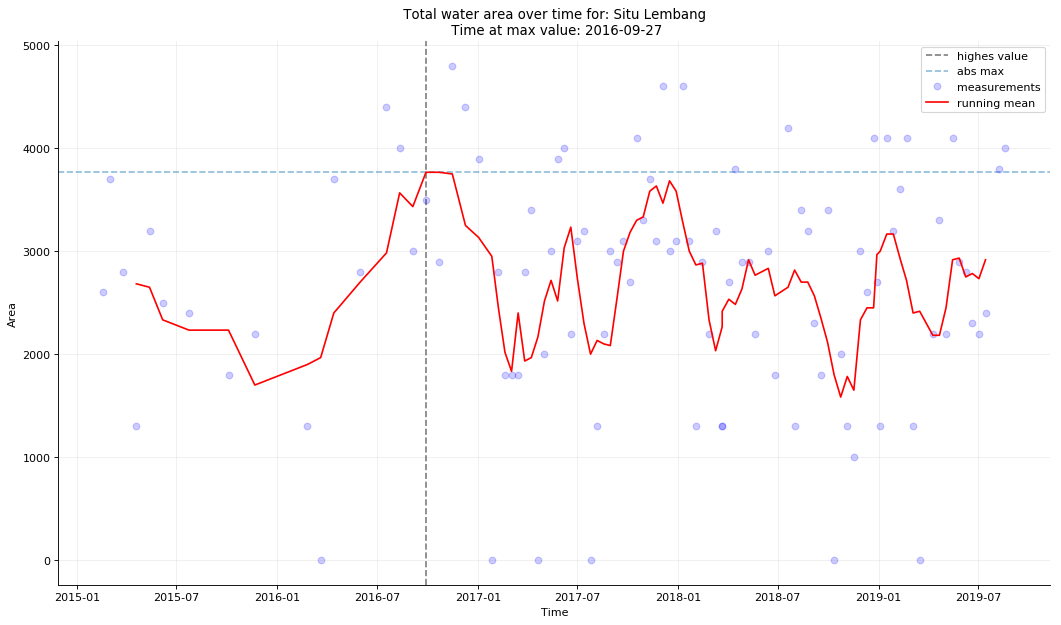

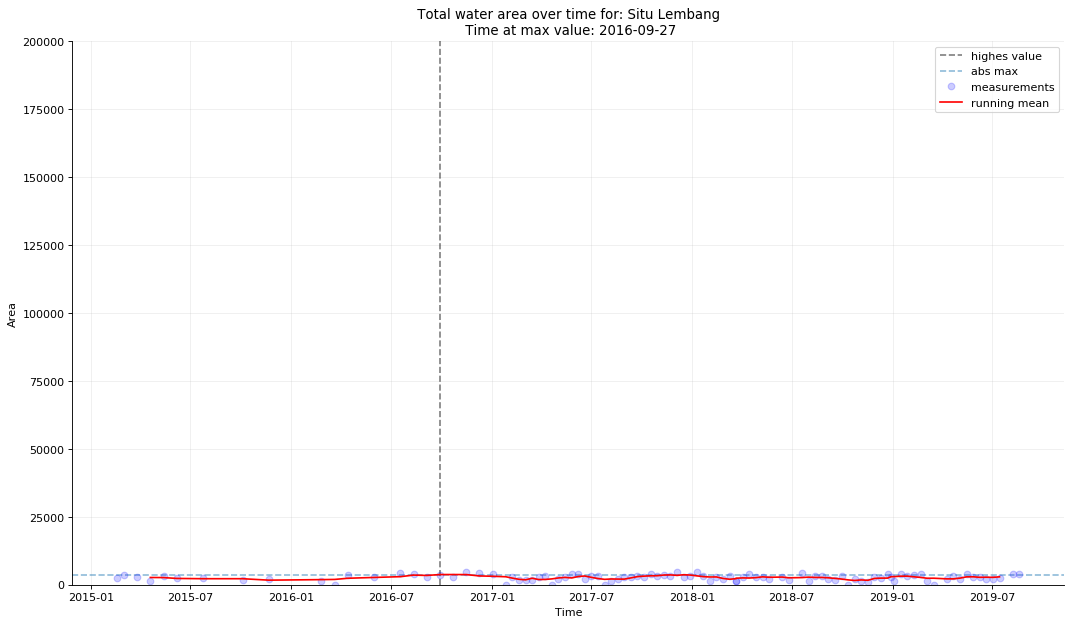

Situ Lembang 2016-09-27 22:33:29.600000


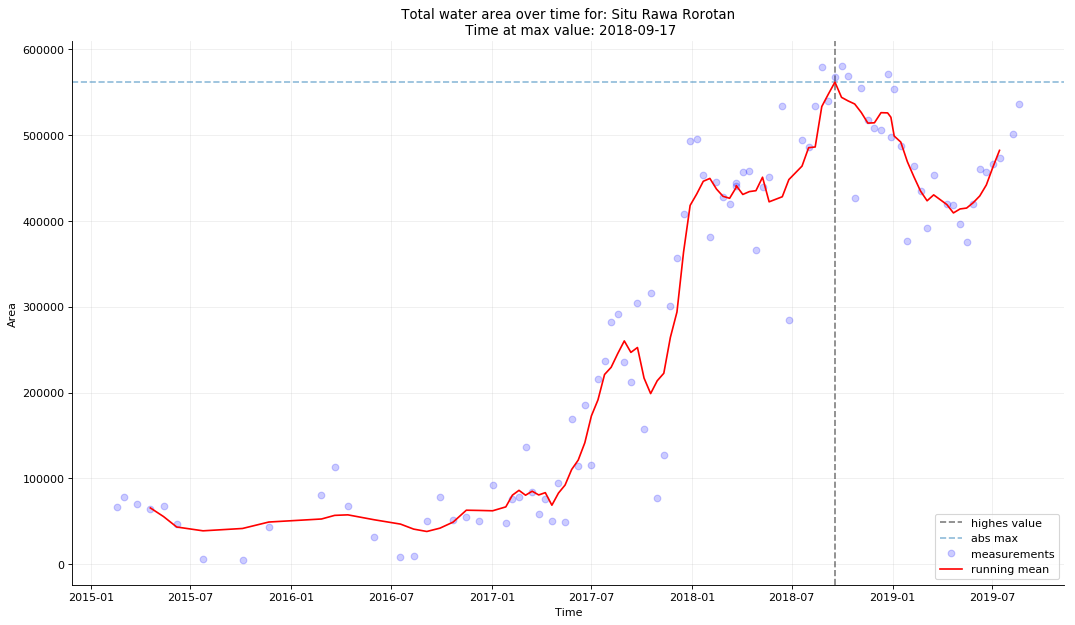

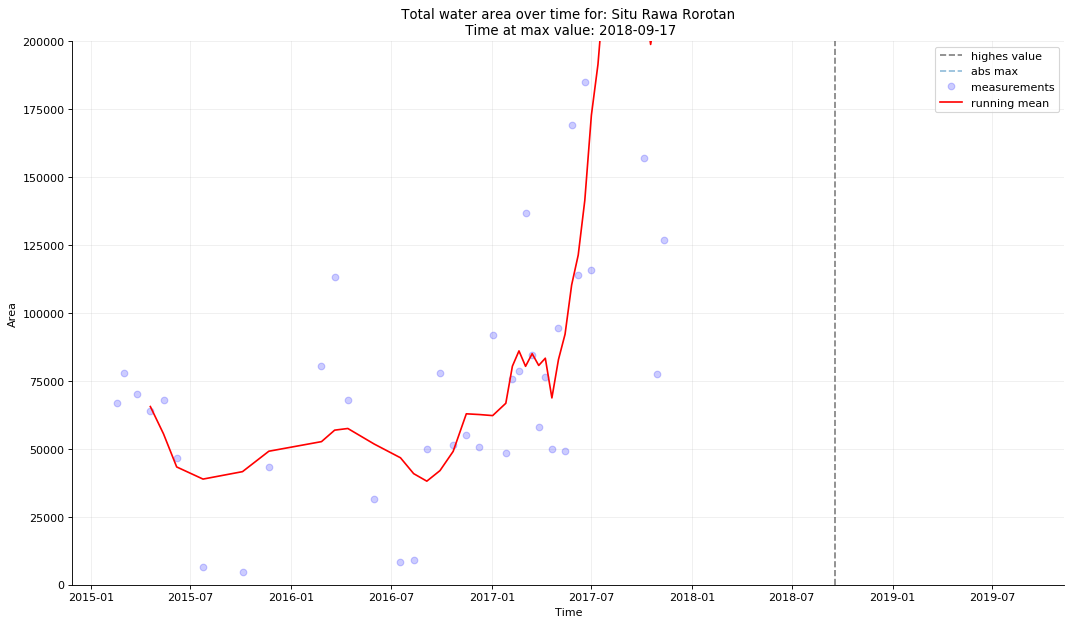

Situ Rawa Rorotan 2018-09-17 22:30:47.850000


In [74]:
for i in [0,12]:

    # set water body of interest
    waterbody_i = i

    #set waterthreshol
    waterThreshold = -12; 

    name = features[waterbody_i].getInfo()['properties']['name']

    # apply buffer to area of interest
    AOI_geometry = ee.FeatureCollection(features[waterbody_i]).map(buffer1k).geometry()


    # apply functions to GEE

    # Get the SAR data from the Sentinel-1 collection.
    S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
        .filterDate('2015-01-01', '2019-12-30')\
        .filterBounds(AOI_geometry)\
        .select(['VV']);

    collection = S1.map(waterfunction);

    withSum = collection.map(setProperty)

    # get time 
    value_time = withSum.aggregate_array('segmentStartTime').getInfo()

    # get data 
    value_mask_size = withSum.aggregate_array('waterArea').getInfo()

    # convert timestamp to DateTime2016-02-25 05:33:19.610
    time = [datetime.datetime.fromtimestamp(int(float(i))/1000) for i in (value_time)]

    ### Reshape data into Pandas Dataframe
    df = pd.DataFrame(data=value_mask_size, index=list(range(len(value_mask_size))),\
                      columns=['size_water'])

    df = df.interpolate()
    df['DateTime'] = pd.Series(time, index=df.index)

    df = df.sort_values('DateTime').reset_index(drop = True)

    # remove outliers
    df = df[np.abs(df.size_water-df.size_water.mean()) <= (3*df.size_water.std())]

    # add running means
    df['roll_mean'] = df['size_water'].rolling(window = 6, center = True).mean()

    index = 2
        
    water_max_plot(df, name, index, zoom = True)
    water_max_plot(df, name, index, zoom = False)    
    
    max_value, t_max = find_max(df, index)
    
    print(name, t_max)

# plot cleaning steps

In [61]:
x[1:10]

1   2015-03-01 22:33:20.280
2   2015-03-25 22:33:20.510
3   2015-04-18 22:33:21.510
4   2015-05-12 22:33:22.680
5   2015-06-05 22:33:24.550
6   2015-07-23 22:33:25.630
7   2015-10-03 22:33:28.470
8   2015-11-20 22:33:22.640
9   2016-02-24 22:33:19.910
Name: DateTime, dtype: datetime64[ns]

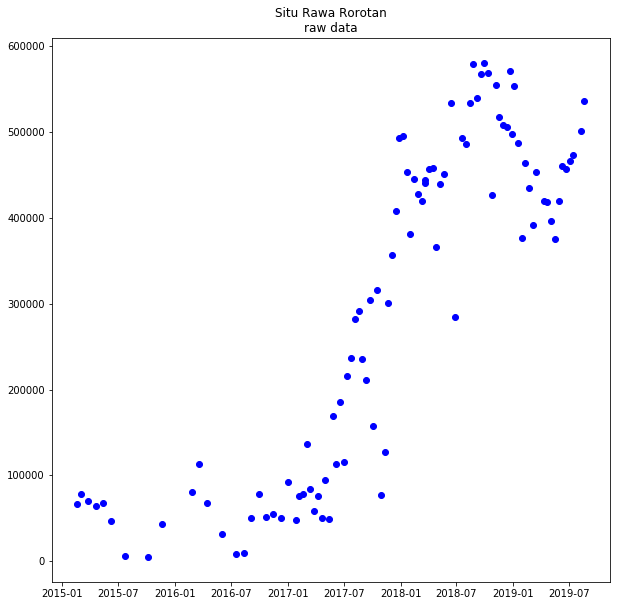

In [78]:
# and visually
plt.figure(figsize= (10,10))
plt.plot(df.DateTime,df.size_water, 'bo')
plt.title(name + '\nraw data')
plt.show()

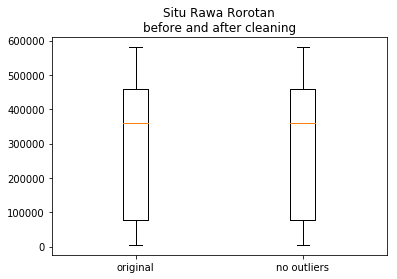

In [79]:
plt.boxplot([value_mask_size, df.size_water], labels=['original', 'no outliers'])
plt.title(name + '\nbefore and after cleaning')
plt.show()

# GBDX integration

In [80]:
 max_value, t_max = find_max(df, index)

In [81]:
t_max

Timestamp('2018-09-17 22:30:47.850000')

In [82]:
import csv

from gbdxtools.task import env
from gbdxtools import Interface, CatalogImage
gbdx = Interface()

%matplotlib inline

In [83]:
from shapely.geometry import shape

### convert ee.geometry to wkt for use in GBDX
# get geometry from ee
AOI_JSON = AOI_geometry.getInfo() 
# convert to shapely shape
geom = shape(AOI_JSON)
# convert to wkt
wkt_string = geom.wkt


In [84]:
type(geom.bounds)

tuple

In [85]:
str_ = ', '.join(map(str, geom.bounds))

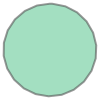

In [89]:
geom

In [90]:
wkt_string

'POLYGON ((106.95598 -6.159325567024252, 106.954715950907 -6.159504642968527, 106.9535525177301 -6.160027616701973, 106.9525823081042 -6.16085286044494, 106.9518825503291 -6.1619146860189, 106.9515089461179 -6.163128573243866, 106.95149123643 -6.164397897390343, 106.9518308334477 -6.1656216202912, 106.9525007073889 -6.166702332968667, 106.9534475374092 -6.167554009586929, 106.9545959555909 -6.168108855454034, 106.9558545463067 -6.168322703864362, 106.9571231233838 -6.168178532072746, 106.958300705658 -6.167687816433564, 106.9592935558325 -6.166889618795562, 106.9600226425122 -6.165847476902662, 106.9604299312657 -6.164644346411155, 106.9604830038941 -6.163375997256904, 106.9601776382998 -6.162143390134925, 106.9595381437904 -6.161044639996327, 106.9586154253693 -6.160167206278073, 106.9574829313114 -6.15958093146696, 106.9562308067147 -6.159332482023588, 106.95598 -6.159325567024252))'

In [91]:
# define filters for GBDX search
filters = [
        "(sensorPlatformName ='WORLDVIEW02' OR sensorPlatformName ='WORLDVIEW03')",
        "cloudCover < 10"
]

In [92]:
# create search window 

search_start = t_max - datetime.timedelta(days = 10) 
search_end = t_max + datetime.timedelta(days = 10)


str_search_start = search_start.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
str_search_end = search_end.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

print("Start: " + str_search_start + "\nEnd: " + str_search_end)

Start: 2018-09-07T22:30:47.850000Z
End: 2018-09-27T22:30:47.850000Z


## Run search on GBDX

In [93]:
results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                          startDate=str_search_start,
                          endDate=str_search_end,
                          filters=filters)

In [94]:
# check number of results
len(results)

1

In [95]:
image_id = results[0]['identifier']
catalog_id = env.inputs.get('catalog_id', image_id)
catalog_id

'1030010085B5FC00'

In [96]:

bbox = env.inputs.get('bbox', ', '.join(map(str, geom.bounds)))


In [97]:
bbox

'106.95149123642997, -6.168322703864362, 106.96048300389414, -6.159325567024252'

In [98]:
img = CatalogImage(catalog_id, bbox=bbox)

TypeError: box() takes from 4 to 5 positional arguments but 78 were given

In [99]:
## Get image from GBDX

# order if not ordered
# otherwise print error and check

try:
    print("try to get image from GBDX...")
    img = CatalogImage(image_id, bbox=bbox)
except:
    
    print("check if image is ordered... ")
    
    ordered = CatalogImage.is_ordered(image_id)
    
    if not ordered:
        order_id = gbdx.ordering.order(image_id)
        
 
        with open('order_id_{}.csv'.format(image_id), newline='') as File:  
            reader = csv.reader(File)
            for row in reader:
                print(row)
                
        print("image {} ordered with order id: {}".format(image_id, order_id))
                
    else:
        print("image ordered is: {}".format(ordered))


        print('image error')

try to get image from GBDX...
check if image is ordered... 
image ordered is: True
image error
